In [1]:
import numpy as np
from scipy.stats import norm
import torch
import gpytorch
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
filename = r'../data/olhs_run1.xlsx'
x_pd = pd.read_excel(filename, sheet_name='Initial Design (OLHS)', header=[0,1], index_col=[0])
y_pd = pd.read_excel(filename, sheet_name='objectives', header=[0,1], index_col=[0])

In [3]:
#normalizing the inputs
xmeans = x_pd.mean(axis=0)
xstddv = x_pd.std(axis=0)
x_pd_normal = (x_pd - xmeans)/xstddv

x_pd = x_pd_normal

In [4]:
#normalize target labels
ymeans = y_pd.mean(axis=0)
ystddv = y_pd.std(axis=0)
y_pd_normal = (y_pd - ymeans)/ystddv

y_pd = y_pd_normal

In [5]:
validation_idx = [1, 7, 15]

train_x_pd = x_pd.drop(validation_idx)
train_y_pd = y_pd.drop(validation_idx)

In [6]:
#make torch tensors
train_x = torch.tensor(train_x_pd.values, dtype=torch.float)
train_y1 = torch.tensor(train_y_pd['Polymer Solubility', 'mg/mL'].values, dtype=torch.float).squeeze()
train_y2 = torch.tensor(train_y_pd['Gelation Enthalpy', 'J/g'].values, dtype=torch.float).squeeze()
train_y3 = torch.tensor(train_y_pd['Shear Modulus', 'Kpa'].values, dtype=torch.float).squeeze()

In [7]:
test_x = torch.tensor(x_pd.values, dtype=torch.float)
test_y = torch.tensor(y_pd.values, dtype=torch.float).squeeze()

In [8]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [9]:
# function to optimize parameters of the regression GP -
def train_reg_gp(model, likelihood, train_x, train_y, training_iter):
   # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        if i - 1  == training_iter:
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                model.covar_module.base_kernel.lengthscale.item(),
                model.likelihood.noise.item()
            ))
        optimizer.step()

    return model, likelihood 

In [10]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model1 = ExactGPModel(train_x, train_y1, likelihood)
model2 = ExactGPModel(train_x, train_y2, likelihood)
model3 = ExactGPModel(train_x, train_y3, likelihood)

In [11]:
training_iter = 50
model1, likl1 = train_reg_gp(model1, likelihood, train_x, train_y1, training_iter)
model2, likl2 = train_reg_gp(model2, likelihood, train_x, train_y2, training_iter)
model3, likl3 = train_reg_gp(model3, likelihood, train_x, train_y3, training_iter)

In [12]:
model1.eval()
likl1.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    pred1 = model1(test_x)
    post_pred1 = likl1(pred1)
    pred_means1 = post_pred1.mean
    pred_std1 = post_pred1.stddev

model2.eval()
likl2.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    pred2 = model2(test_x)
    post_pred2 = likl2(pred2)
    pred_means2 = post_pred2.mean
    pred_std2 = post_pred2.stddev
    
model3.eval()
likl3.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    pred3 = model3(test_x)
    post_pred3 = likl3(pred3)
    pred_means3 = post_pred3.mean
    pred_std3 = post_pred3.stddev

pred_means = torch.stack((pred_means1, pred_means2, pred_means3), dim=1)

In [13]:
pred_means = pred_means * ystddv.values + ymeans.values
test_y = test_y * ystddv.values + ymeans.values

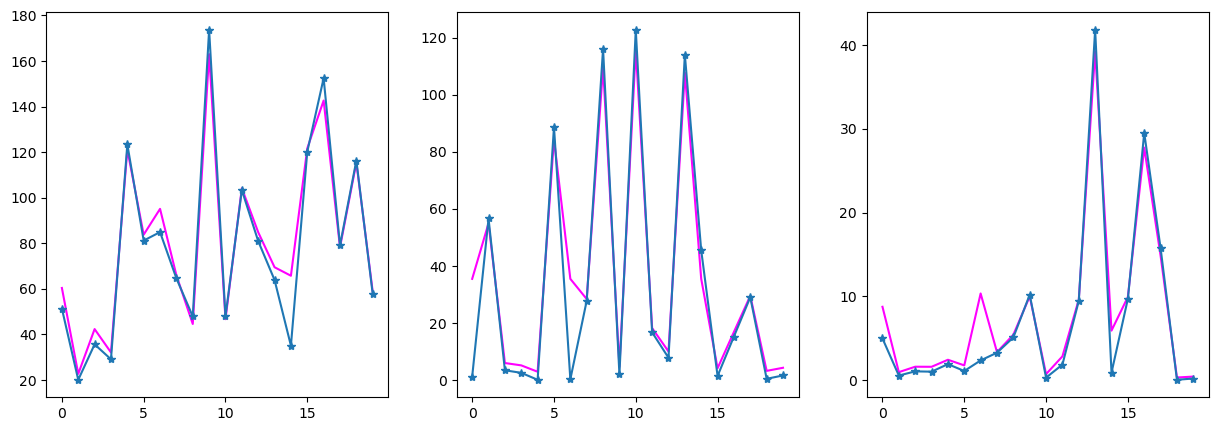

In [15]:
#Plots 
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

for i in range(3):
    im = ax[i].plot(pred_means[:, i], color='magenta')
    ax[i].plot(test_y[:, i], '-*')
plt.show()

**Comment on property prediction**

Four objectives were included in the original data - Polymer solubility, Gelation Enthalpy, shear modulus, and ion conductivity.
Only three are modeled here (ion conductivity is dropped out). Reason - Ion conductivity includes and outlier (error or true? not known).
With 20 points for an 8D space, the fit is okay. We can build BO based on this 